# 1. Import Libraries


In [2]:
import pandas as pd
import numpy as np
import glob
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score



# 2. load & Merge Data

In [3]:

files=glob.glob("data/uber-raw-data-*.csv")

df_list=[pd.read_csv(file)  for file in files]
df=pd.concat(df_list,ignore_index=True)

print("Total Records:",len(df))
df.head()

Total Records: 4534327


,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


# 3. Data cleaning & Feature Engineering

In [4]:
df.isnull().sum()

Date/Time    0
Lat          0
Lon          0
Base         0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4534327 entries, 0 to 4534326
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Date/Time  object 
 1   Lat        float64
 2   Lon        float64
 3   Base       object 
dtypes: float64(2), object(2)
memory usage: 138.4+ MB


### Convert Date

In [6]:
df['Date/Time']=pd.to_datetime(df['Date/Time'])

### Create Time Feature

In [7]:
df['Hour']=df['Date/Time'].dt.hour
df['Day']=df['Date/Time'].dt.day
df['Month']=df['Date/Time'].dt.month
df['DayOfWeek']=df['Date/Time'].dt.dayofweek
df['Week']=df['Date/Time'].dt.isocalendar().week

# 4. Sql Analysis (DuckDB)

#### Total trip

In [11]:
duckdb.query("""
SELECT COUNT(*) AS total_trips
FROM df
""").df()

,total_trips
0,4534327


#### Trips per hour

In [21]:
hour_sql =duckdb.query("""
SELECT Hour, COUNT(*) AS total_trips
FROM df
GROUP BY Hour
ORDER BY Hour
""").df()
hour_sql

,Hour,total_trips
0,0,103836
1,1,67227
2,2,45865
3,3,48287
4,4,55230
5,5,83939
6,6,143213
7,7,193094
8,8,190504
9,9,159967


#### Trips Per Day

In [13]:
duckdb.query("""
SELECT DayOfWeek, COUNT(*) AS total_trips
FROM df
GROUP BY DayOfWeek
ORDER BY DayOfWeek
""").df()

,DayOfWeek,total_trips
0,0,541472
1,1,663789
2,2,696488
3,3,755145
4,4,741139
5,5,646114
6,6,490180


#### Monthly Growth

In [33]:
month_sql =duckdb.query("""
SELECT Month, COUNT(*) AS total_trips
FROM df
GROUP BY Month
ORDER BY Month
""").df()
month_sql

,Month,total_trips
0,4,564516
1,5,652435
2,6,663844
3,7,796121
4,8,829275
5,9,1028136


#### Base Performance

In [15]:
duckdb.query("""
SELECT 
    Base,
    COUNT(*) AS total_trips
FROM df
GROUP BY Base
ORDER BY total_trips DESC
""").df()


,Base,total_trips
0,B02617,1458853
1,B02598,1393113
2,B02682,1212789
3,B02764,263899
4,B02512,205673


#### Daily Trend

In [16]:
duckdb.query("""
SELECT 
    DATE("Date/Time") AS trip_date,
    COUNT(*) AS total_trips
FROM df
GROUP BY trip_date
ORDER BY trip_date
""").df()


,trip_date,total_trips
0,2014-04-01,14546
1,2014-04-02,17474
2,2014-04-03,20701
3,2014-04-04,26714
4,2014-04-05,19521
...,...,...
178,2014-09-26,37504
179,2014-09-27,39468
180,2014-09-28,29656
181,2014-09-29,29201


# 5. Exploratory Data Analysis (EDA)

#### Trips Per Hour

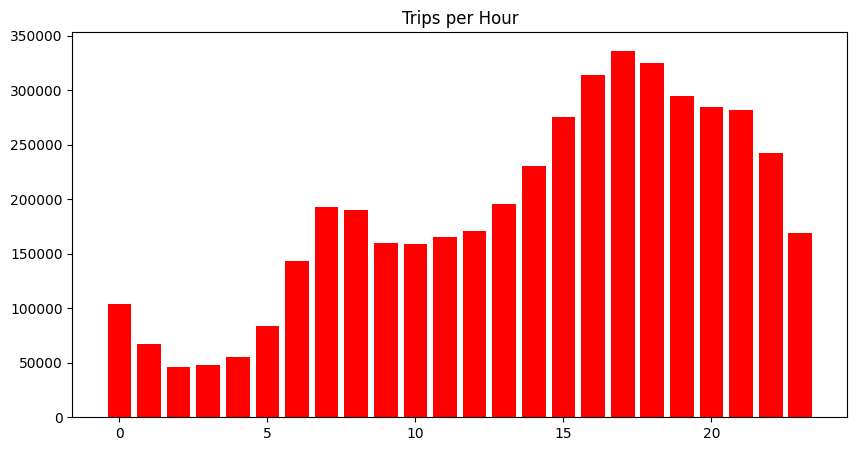

In [23]:
plt.figure(figsize=(10,5))
plt.bar(hour_sql['Hour'], hour_sql['total_trips'],color='red')
plt.title("Trips per Hour")
plt.show()


#### Trips Per Day of Week

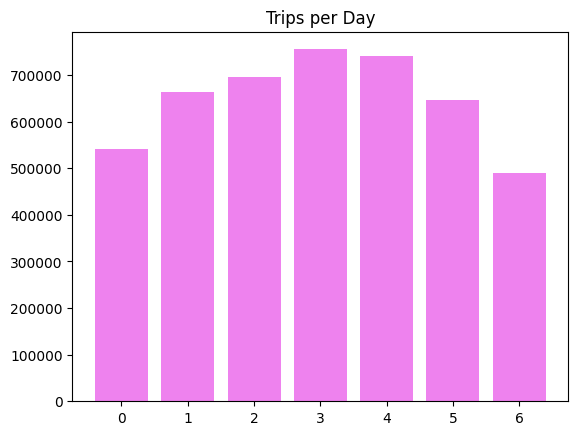

In [26]:
daily = df.groupby('DayOfWeek').size()

plt.bar(daily.index, daily.values,color='violet')
plt.title("Trips per Day")
plt.show()


#### Monthly Trend

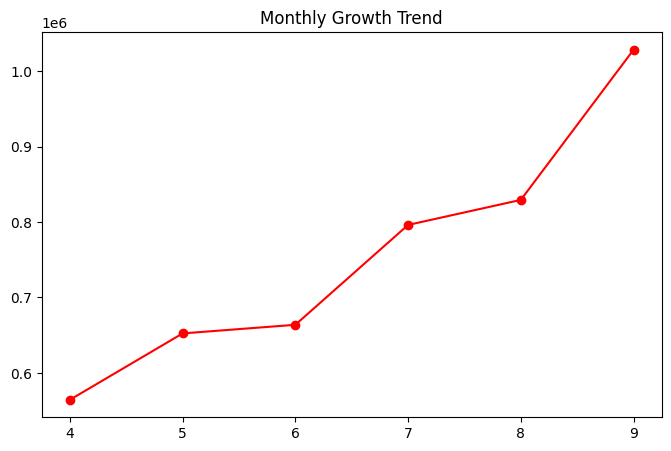

In [38]:
plt.figure(figsize=(8,5))
plt.plot(month_sql['Month'], month_sql['total_trips'], marker='o',color='red')
plt.title("Monthly Growth Trend")
plt.show()


#### Heatmap (Hour vs Day)

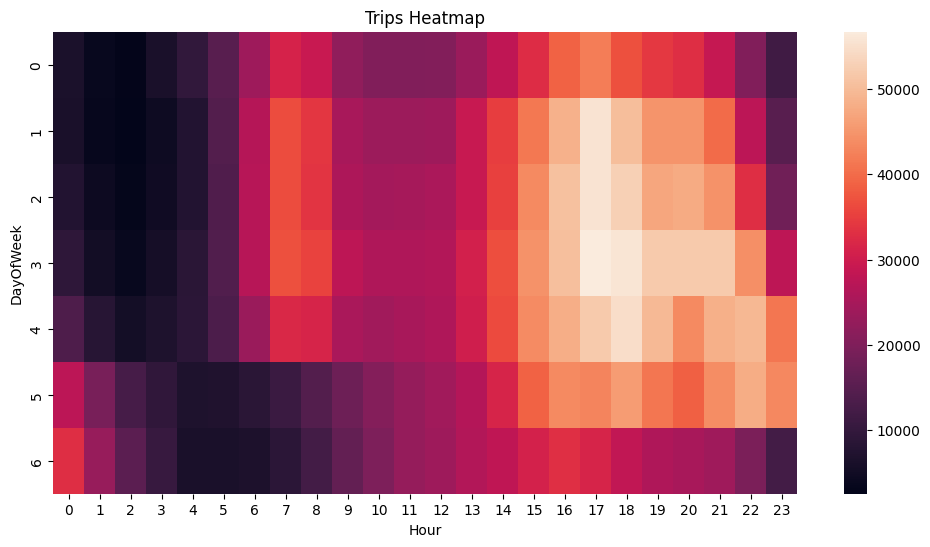

In [44]:
heatmap_data = df.groupby(['DayOfWeek','Hour']).size().unstack()

plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data)
plt.title("Trips Heatmap")
plt.show()


# 6. Time Series Analysis

#### Hourly Time Trend

C:\Users\mbima\AppData\Local\Temp\ipykernel_19212\3860566218.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_trend = df.resample('H').size()


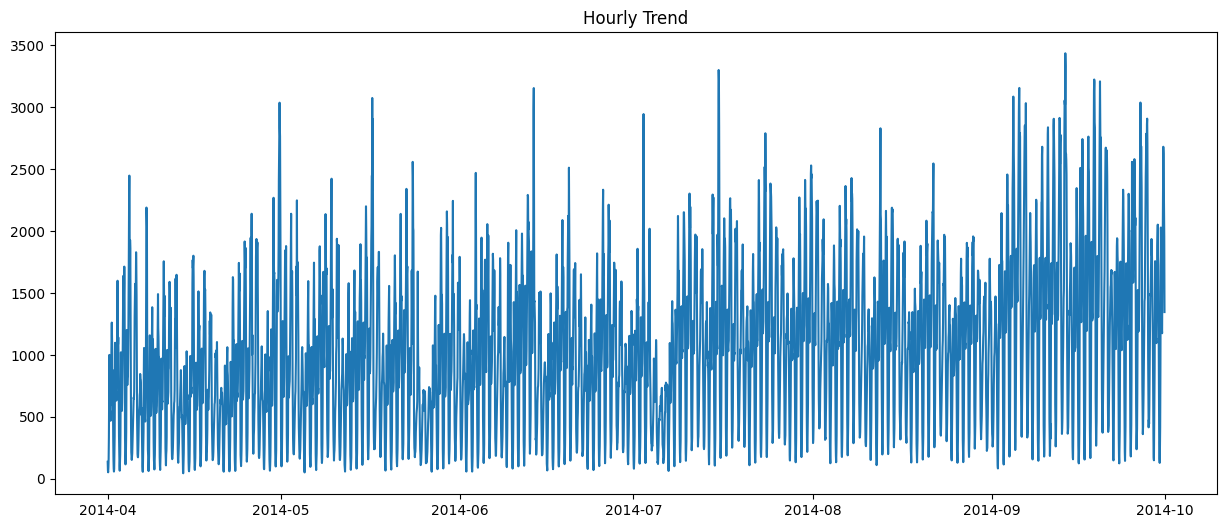

In [59]:
# df.set_index('Date/Time', inplace=True)

hourly_trend = df.resample('H').size()
# hourly_trend

plt.figure(figsize=(15,6))
plt.plot(hourly_trend)
plt.title("Hourly Trend")
plt.show()


#### Seasonal Decomposition

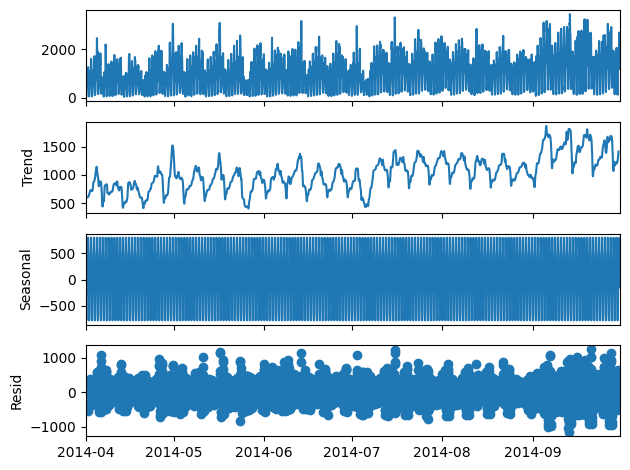

In [60]:
result = seasonal_decompose(hourly_trend, model='add', period=24)
result.plot()
plt.show()


# 7. Statistical Analysis

#### Check Distribution

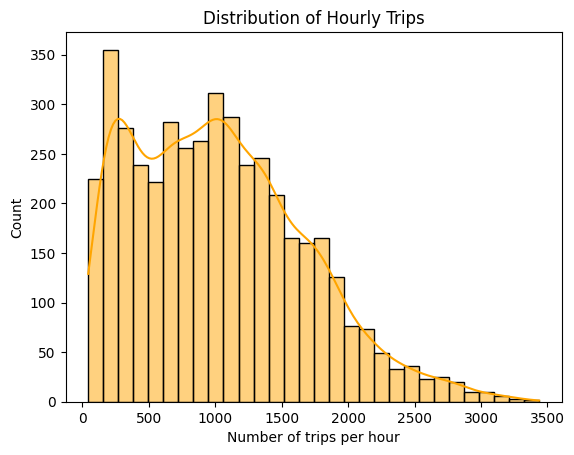

In [66]:
sns.histplot(hourly_trend, kde=True,color='orange')
plt.title("Distribution of Hourly Trips")
plt.xlabel("Number of trips per hour")
plt.show()


#### Correlation

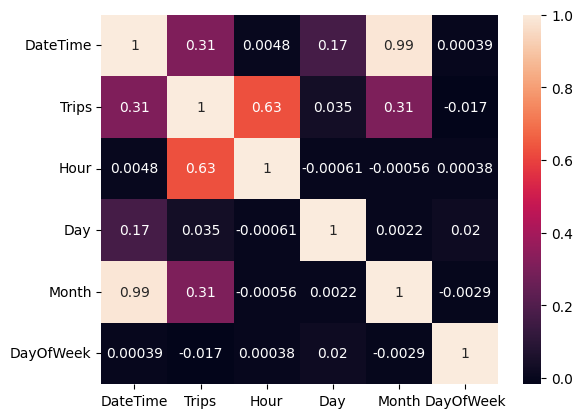

In [74]:
hourly_df = hourly_trend.reset_index()
hourly_df.columns = ['DateTime','Trips']

hourly_df['Hour'] = hourly_df['DateTime'].dt.hour
hourly_df['Day'] = hourly_df['DateTime'].dt.day
hourly_df['Month'] = hourly_df['DateTime'].dt.month
hourly_df['DayOfWeek'] = hourly_df['DateTime'].dt.dayofweek


sns.heatmap(hourly_df.corr(), annot=True)
plt.show()


# 8. Predictive Modeling

#### Preaper Features

In [75]:
X = hourly_df[['Hour','Day','Month','DayOfWeek']]
y = hourly_df['Trips']


#### Train/Test Split

In [76]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


#### Train Random Forest

In [77]:
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

pred = model.predict(X_test)


#### Evaluate Model

In [78]:
print("MAE:", mean_absolute_error(y_test, pred))
print("R2:", r2_score(y_test, pred))


MAE: 96.57575085324233
R2: 0.9423267753050337


#### Actual vs Predicted

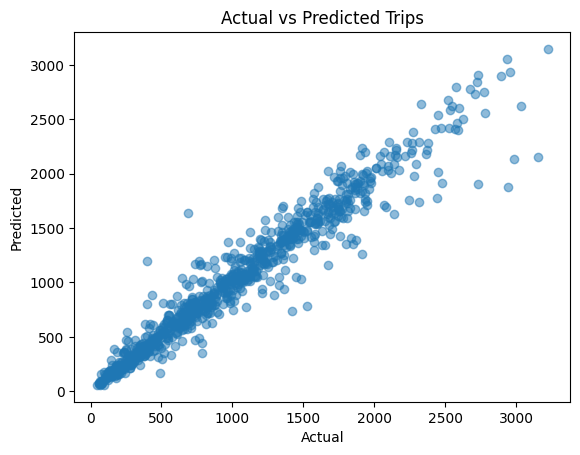

In [79]:
plt.scatter(y_test, pred, alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Trips")
plt.show()


# 9.Advanced Feature Engineering(Lag Features)

In [80]:
hourly_df['Lag_1'] = hourly_df['Trips'].shift(1)
hourly_df['Lag_24'] = hourly_df['Trips'].shift(24)

hourly_df = hourly_df.dropna()

X = hourly_df[['Hour','Day','Month','DayOfWeek','Lag_1','Lag_24']]
y = hourly_df['Trips']


#### train again

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

model = RandomForestRegressor(n_estimators=200)
model.fit(X_train,y_train)

pred = model.predict(X_test)

print("Improved MAE:", mean_absolute_error(y_test,pred))


Improved MAE: 74.25950228832951
